In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
%matplotlib inline
sys.path.append("..")

In [2]:
TEST_PATH = '../data/stage1_test'

In [3]:
from utils.preprocessing import create_data
from utils.dataset import create_dataloader
from utils.preprocessing import create_data, load_data, train_val_split
from utils.evaluation import calculate_thresholded_precision, create_thresholded_mask
from utils.cuda import cudarize
from utils.loss import soft_dice_loss
from model import UNet

In [4]:
test = create_data(TEST_PATH)

100%|██████████| 65/65 [00:00<00:00, 849313.89it/s]


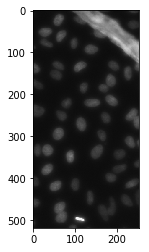

In [5]:
plt.imshow(test[48]['image'])

In [6]:
test_dl = create_dataloader(test, is_test=True, shuffle=False)

In [7]:
model = cudarize(UNet(n_input_channels=3, n_classes=1))
model.eval()

UNet(
  (bridge): Bridge(
    (bridge): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU()
      )
      (1): ConvBlock(
        (conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU()
      )
    )
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (conv_block_1): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU()
      )
      (conv_block_2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU()
      )
      (pool): MaxPool2d(kernel_size=(2, 2), s

In [8]:
model.load_state_dict(torch.load("../model_checkpoints/20180321-231024/epoch_7.iou_0.835.loss_0.165.pth"))

In [44]:
res = []
for b in test_dl:
    inp = cudarize(Variable(b['input']))
    preds = F.sigmoid(model(inp)).cpu().data.numpy()
    shapes = b['shape'].numpy()
    b.update(dict(id=np.array(b['id']),
                  preds=preds,
                  shapes=shapes))
    res.append(b)

In [55]:
all_ids = np.concatenate([r['id'] for r in res])
all_input = np.transpose(np.concatenate([r['input'] for r in res]), (0, 2, 3, 1))
all_preds = np.concatenate([r['preds'] for r in res]).squeeze()
all_shapes = np.concatenate([r['shapes'] for r in res])

In [57]:
import cv2
all_reshaped_inputs = []
all_reshaped_preds = []
for inp, pred, shape in zip(all_input, all_preds, all_shapes):
    all_reshaped_inputs.append(cv2.resize(inp, (shape[1], shape[0])))
    all_reshaped_preds.append(cv2.resize(pred, (shape[1], shape[0])))

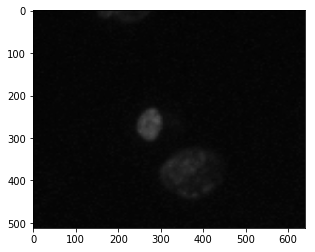

In [58]:
import random
idx = random.choice(range(len(all_reshaped_inputs)))
plt.imshow(all_reshaped_inputs[idx])

In [59]:
all_reshaped_preds[idx].shape

(512, 640)

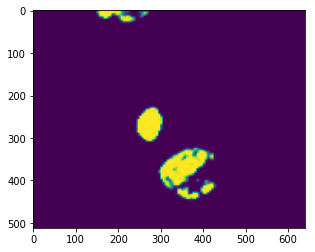

In [60]:
plt.imshow(all_reshaped_preds[idx])

In [61]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join(map(str, run_lengths))

In [62]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if type(mask_rle) == str:
        s = mask_rle.split()
    else:
        s = mask_rle
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [66]:
from skimage import morphology
def prob_to_rles(pred, cutoff=0.5, debug=False, dilation=True):
    lab_img = morphology.label(pred > cutoff) # split of components goes here
    if debug:
        plt.imshow(lab_img)
        plt.show() 
        lab_img2=lab_img
    if dilation:
        for i in range(1, lab_img.max() + 1):    
            lab_img = np.maximum(lab_img, ndimage.morphology.binary_dilation(lab_img==i)*i)
        if debug:
            plt.imshow(lab_img)
            plt.show()    
    for i in range(1, lab_img.max() + 1):
        img = lab_img == i
        yield rle_encoding(img)

ModuleNotFoundError: No module named 'skimage'

In [64]:
image_ids = []
rles = []
for image_id, pred_mask in zip(all_ids, all_reshaped_preds):
    rle = list(prob_to_rles(pred_mask))
    rles.extend(rle)
    all_ids.extend([image_id] * len(rle))

NameError: name 'morphology' is not defined

In [54]:
all_ids

[]

In [184]:
all_rles = [rle_encoding(mask) for mask in all_reshaped_masks]

In [196]:
df_data = []
for image_id, rle in zip(all_ids, all_rles):
    df_data.append(dict(ImageId=image_id, EncodedPixels=rle))

In [197]:
df = pd.DataFrame(df_data)[["ImageId", "EncodedPixels"]]

In [198]:
df.to_csv("submission.csv",index=False)

In [199]:
df

,ImageId,EncodedPixels
0,336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...,80 8 258 21 311 12 360 12 433 32 599 8 777 21 ...
1,b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65...,265 4 425 4 490 4 789 4 949 4 1014 4 1313 4 14...
2,4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d...,16 6 164 16 232 10 272 6 420 16 488 10 528 6 6...
3,191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107...,13252 2 13508 2 13762 8 14018 8 14272 10 14528...
4,8922a6ac8fd0258ec27738ca101867169b20d90a60fc84...,24543 20 25055 20 25567 20 26079 20 26591 20 2...
5,8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7...,76 37 186 8 218 33 401 53 596 37 706 8 738 33 ...
6,9f17aea854db13015d19b34cb2022cfdeda44133323fcd...,83207 16 83719 16 84231 16 84743 16 85255 16 1...
7,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,52 16 177 13 413 36 571 16 696 13 932 36 1090 ...
8,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,23 8 68 12 145 12 242 4 307 4 327 4 356 12 396...
9,3c4c675825f7509877bc10497f498c9a2e3433bf922bd8...,2406 8 2537 4 2930 8 3061 4 3454 8 3585 4 3978...
